In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

In [2]:
path = r'C:\Users\erosb\08-2023 Instacart Basket Analysis'

#### #1 import data

In [3]:
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_all.pkl'))

#### #2 Security implications 

In [7]:
df.columns

Index(['user_id', 'first_name', 'last_name', 'Gender', 'STATE', 'Age',
       'date_joined', 'n_dependants', 'fam_status', 'income', 'order_id',
       'order_number', 'orders_day_of_week', 'hour_order_placed',
       'days_since_prior_order', 'product_id', 'add_to_cart_order',
       'reordered', '_merge', 'product_name', 'aisle_id', 'department_id',
       'prices', '_exist', 'price_range_loc', 'busiest_day',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_price',
       'spending_flag', 'med_dspo', 'frequency_flag'],
      dtype='object')

There are a number of columns in the data that is PII including first_name, last_name, gender, age, n_dependants, fam_status, income. If these were real customers, steps would need to be taken to ensure privacy for the customers. In fact, the first and last name is not likely significant to any analyses other than ensuring there are not duplicates, and therefore could be deleted or removed from the general dataset.

#### #3 Regional segmentation

In [21]:
#make region lists
ne_list = ['Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey']
mw_list = ['Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota', 'Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri']
so_list = ['Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana']
we_list = ['Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii']

In [22]:
#create region column based on state
#first, define a function
def region_label(row):
    if row['STATE'] in (ne_list):
        return 'Northeast'
    elif row['STATE'] in(mw_list):
        return 'Midwest'
    elif row['STATE'] in(so_list):
        return 'South'
    elif row['STATE'] in (we_list):
        return 'West'
    else:
        return 'Unknown'

In [30]:
df['Region'] = df.apply(region_label, axis = 1)

In [24]:
#determine whether there's a difference in spending habits across regions
#crosstab spending flag with region
crosstab = pd.crosstab(df['spending_flag'], df['Region'], dropna=False)

In [25]:
#copy to clipboard
crosstab.to_clipboard()

In [26]:
df['spending_flag'].value_counts(dropna=False)

Low spender     31770614
High spender      634245
Name: spending_flag, dtype: int64

Results: after viewing the summary in Excel and visualizing with a stacked bar chart, there is no significant difference in spending habits among regions. In every region, the high spenders make up about 2% of the population.

#### #4 Exclude low-activity customers

In [67]:
df = df.drop(df[df.order_number <5].index)

In [6]:
df.shape

(32404859, 33)

Successful - decreased number of rows

In [33]:
#export
df.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_excluded_low_activity.pkl'))

In [8]:
df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_excluded_low_activity.pkl'))
#delete at end!

In [9]:
df.columns

Index(['user_id', 'first_name', 'last_name', 'Gender', 'STATE', 'Age',
       'date_joined', 'n_dependants', 'fam_status', 'income', 'order_id',
       'order_number', 'orders_day_of_week', 'hour_order_placed',
       'days_since_prior_order', 'product_id', 'add_to_cart_order',
       'reordered', '_merge', 'product_name', 'aisle_id', 'department_id',
       'prices', '_exist', 'price_range_loc', 'busiest_day',
       'busiest_period_of_day', 'max_order', 'loyalty_flag', 'avg_price',
       'spending_flag', 'med_dspo', 'frequency_flag', 'Region', 'pet_flag',
       'parent_flag', 'age_flag', 'income_flag', 'cust_profile'],
      dtype='object')

#### #5 Customer Profiling

In [4]:
def age_label(row):
    if row['Age']<30:
        return 'Young '
    elif row ['Age']>60:
        return 'Older '
    else:
        return 'Middle-aged '

In [20]:
def income_label(row):
    if row['income']<40000:
        return 'Low-income '
    elif row['income']>115000:
        return 'Upper-income '
    else:
        return 'Middle-income '

In [7]:
df.loc[df['n_dependants']>=1, 'parent_flag'] = 'Parent '

In [40]:
df.loc[df['n_dependants']==0, 'parent_flag'] = 'Non-Parent '

In [8]:
df['age_flag']=df.apply(age_label, axis=1)

In [37]:
df['income_flag']=df.apply(income_label, axis=1)

In [41]:
df['cust_profile']=df['age_flag']+df['income_flag']+df['parent_flag']

In [42]:
df['cust_profile'].value_counts(dropna=False)

Middle-aged Middle-income Parent         5457235
Young Middle-income Parent               3166681
Older Upper-income Parent                3081377
Middle-aged Upper-income Parent          2988610
Older Middle-income Parent               2641182
Middle-aged Middle-income Non-Parent     1798899
Young Middle-income Non-Parent           1046088
Older Upper-income Non-Parent            1031549
Middle-aged Upper-income Non-Parent      1016051
Older Middle-income Non-Parent            886852
Middle-aged Low-income Parent             443764
Older Low-income Parent                   245505
Young Low-income Parent                   236590
Middle-aged Low-income Non-Parent         151199
Older Low-income Non-Parent                82394
Young Low-income Non-Parent                80400
Young Upper-income Parent                  48931
Young Upper-income Non-Parent              11570
Name: cust_profile, dtype: int64

#### #6 Visualize customer profile distribution

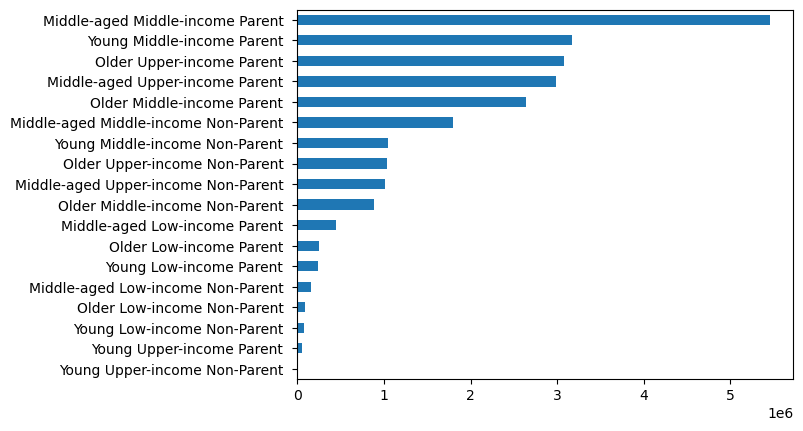

In [108]:
prof_bar = df['cust_profile'].value_counts(dropna=False, ascending=True).plot.barh()

In [109]:
prof_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'profiles_bar.png'))

#### #7 Aggregate summary statistics for customer profiles

In [64]:
df.groupby('cust_profile').agg({'days_since_prior_order':['max', 'mean', 'min'], 'prices':['max', 'mean', 'min']})

days_since_prior_order                  \
                                                         max       mean  min   
cust_profile                                                                   
Middle-aged Low-income Non-Parent                       30.0  10.412324  0.0   
Middle-aged Low-income Parent                           30.0  10.502039  0.0   
Middle-aged Middle-income Non-Parent                    30.0  10.039743  0.0   
Middle-aged Middle-income Parent                        30.0  10.068038  0.0   
Middle-aged Upper-income Non-Parent                     30.0   9.967797  0.0   
Middle-aged Upper-income Parent                         30.0  10.115885  0.0   
Older Low-income Non-Parent                             30.0   9.997864  0.0   
Older Low-income Parent                                 30.0  10.608032  0.0   
Older Middle-income Non-Parent                          30.0  10.093866  0.0   
Older Middle-income Parent                              30.0  10.134555  0.0   
Older Upper-income Non-Parent                           30.0   9.975899  0.0   
Older Upper-income Parent                               30.0  10.004012  0.0   
Young Low-income Non-Parent                             30.0  10.649030  0.0   
Young Low-income Parent                                 30.0  10.390524  0.0   
Young Middle-income Non-Parent                          30.0  10.169232  0.0   
Young Middle-income Parent                              30.0  10.055143  0.0   
Young Upper-income Non-Parent                           30.0   9.954105  0.0   
Young Upper-income Parent                               30.0   9.356522  0.0   

                                      prices                 
                                         max      mean  min  
cust_profile                                                 
Middle-aged Low-income Non-Parent       25.0  6.493856  1.0  
Middle-aged Low-income Parent           25.0  6.503885  1.0  
Middle-aged Middle-income Non-Parent    25.0  7.815079  1.0  
Middle-aged Middle-income Parent        25.0  7.808700  1.0  
Middle-aged Upper-income Non-Parent     25.0  7.938985  1.0  
Middle-aged Upper-income Parent         25.0  7.947646  1.0  
Older Low-income Non-Parent             25.0  6.535935  1.0  
Older Low-income Parent                 25.0  6.521951  1.0  
Older Middle-income Non-Parent          25.0  7.748867  1.0  
Older Middle-income Parent              25.0  7.724127  1.0  
Older Upper-income Non-Parent           25.0  7.947230  1.0  
Older Upper-income Parent               25.0  7.955901  1.0  
Young Low-income Non-Parent             25.0  6.484073  1.0  
Young Low-income Parent                 25.0  6.492751  1.0  
Young Middle-income Non-Parent          25.0  7.873993  1.0  
Young Middle-income Parent              25.0  7.881358  1.0  
Young Upper-income Non-Parent           25.0  7.821661  1.0  
Young Upper-income Parent               25.0  7.789210  1.0

#### #8 Compare profiles with regions and departments

In [97]:
df.head()

,user_id,first_name,last_name,Gender,STATE,Age,date_joined,n_dependants,fam_status,income,...,avg_price,spending_flag,med_dspo,frequency_flag,Region,pet_flag,parent_flag,age_flag,income_flag,cust_profile
0,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,7.988889,Low spender,19.0,Regular customer,Midwest,NaN,Parent,Middle-aged,Upper-income,Middle-aged Upper-income Parent
1,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,7.988889,Low spender,19.0,Regular customer,Midwest,NaN,Parent,Middle-aged,Upper-income,Middle-aged Upper-income Parent
2,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,7.988889,Low spender,19.0,Regular customer,Midwest,NaN,Parent,Middle-aged,Upper-income,Middle-aged Upper-income Parent
6,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,7.988889,Low spender,19.0,Regular customer,Midwest,NaN,Parent,Middle-aged,Upper-income,Middle-aged Upper-income Parent
7,26711,Deborah,Esquivel,Female,Missouri,48,1/1/2017,3,married,165665,...,7.988889,Low spender,19.0,Regular customer,Midwest,NaN,Parent,Middle-aged,Upper-income,Middle-aged Upper-income Parent


In [78]:
reg_dep = pd.crosstab(df['department_id'], df['Region'], dropna=False)

In [72]:
reg_dep

Region,Midwest,Northeast,South,West
department_id,,,,
1,381094,283259,545809,417452
2,6284,4932,9200,6750
3,205374,157635,292772,227549
4,1695851,1269360,2409221,1852659
5,25567,18534,36253,27618
6,46607,34491,65417,51385
7,472243,367868,680594,515742
8,16481,14080,23012,18538
9,148529,110708,210680,163808


<function matplotlib.pyplot.legend(*args, **kwargs)>

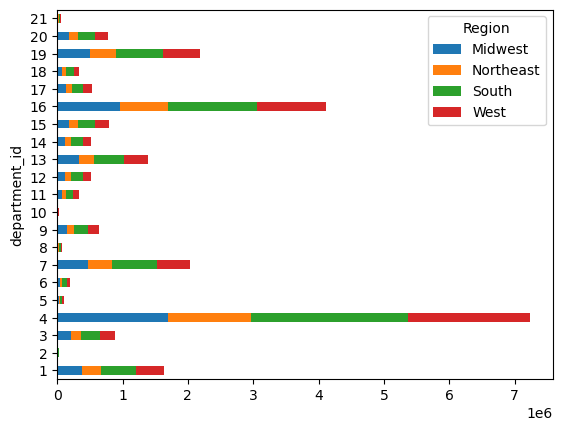

In [88]:
reg_dep_bar = reg_dep.plot.barh(stacked=True)
plt.legend

In [110]:
reg_dep_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'reg_dep_bar.png'))

In [87]:
df.groupby('Region').agg({'order_number':['mean'], 'prices':[ 'mean']})

,order_number,prices
,mean,mean
Region,,
Midwest,21.702417,7.790719
Northeast,22.031923,7.781979
South,21.965822,7.795570
West,22.098505,7.790263


Very little difference in mean prices across regions. 

In [91]:
prof_dep = pd.crosstab(df['department_id'], df['parent_flag'], dropna=False)

<function matplotlib.pyplot.legend(*args, **kwargs)>

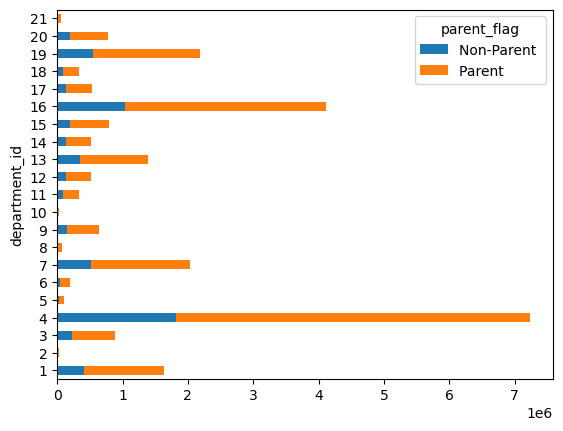

In [92]:
prof_dep_bar = prof_dep.plot.barh(stacked=True)
plt.legend

In [111]:
prof_dep_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'prof_dep_bar.png'))

In [10]:
age_freq = pd.crosstab(df['frequency_flag'], df['age_flag'], dropna=False)

In [106]:
age_freq

age_flag,Middle-aged,Older,Young
frequency_flag,,,
Frequent customer,8785818,5935418,3415522
Non-frequent customer,712904,475461,275153
Regular customer,2357036,1557980,899585


(array([0, 1, 2]),
 [Text(0, 0, 'Frequent customer'),
  Text(1, 0, 'Non-frequent customer'),
  Text(2, 0, 'Regular customer')])

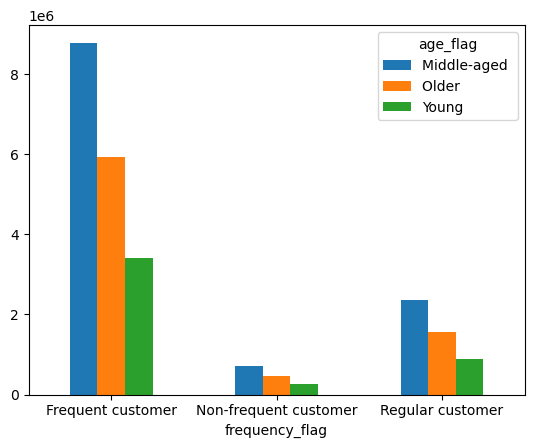

In [13]:
age_freq_bar = age_freq.plot.bar()
plt.xticks(rotation=0)

In [14]:
age_freq_bar.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'age_freq_bar.png'))